# Chapter 4: Machine Learning state of the art
## Figure 4.4
Overfit/oversmooth for classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVC


plt.style.use('seaborn-paper')
plt.rc('text', usetex=False)

### Classification
Data source https://archive.ics.uci.edu/ml/datasets/HTRU2
HTRU2 is a data set which describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey (South) [1].

8 Variables:
	1. Mean of the integrated profile.
	2. Standard deviation of the integrated profile.
	3. Excess kurtosis of the integrated profile.
	4. Skewness of the integrated profile.
	5. Mean of the DM-SNR curve.
	6. Standard deviation of the DM-SNR curve.
	7. Excess kurtosis of the DM-SNR curve.
	8. Skewness of the DM-SNR curve.
1 Label:
	9. Pulsar.

In [2]:
df = pd.read_csv('../data/HTRU2/HTRU_2.csv', header=0)
df.head()

,MOTIP,SDOFIP,EKOTIP,SOTIP,MOTDC,SDOTDC,EKOTDC,SOTDC,Pulsar
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [3]:
features = df.columns.drop('Pulsar')
print(features)

X = df[features].values
y = df['Pulsar'].values
print(X.shape)
print(y.shape)

Index([u'MOTIP', u'SDOFIP', u'EKOTIP', u'SOTIP', u'MOTDC', u'SDOTDC',
       u'EKOTDC', u'SOTDC'],
      dtype='object')
(17898, 8)
(17898,)


In [4]:
# identify the two classes
pulsar = np.where(y == 1)[0]
non_pulsar = np.where(y == 0)[0]

print(len(pulsar))
print(len(non_pulsar))

# create a reduced and manually-balanced
samples_per_class = 200
np.random.shuffle(pulsar)
np.random.shuffle(non_pulsar)

idx = np.vstack((pulsar[:samples_per_class], non_pulsar[:samples_per_class])).ravel()
print(len(idx))

1639
16259
400


In [5]:
from sklearn.manifold import TSNE

ss = StandardScaler()
tsne = TSNE(perplexity=100, init='pca')

X_ss = ss.fit_transform(X[idx, :])
X_r = tsne.fit_transform(X_ss)

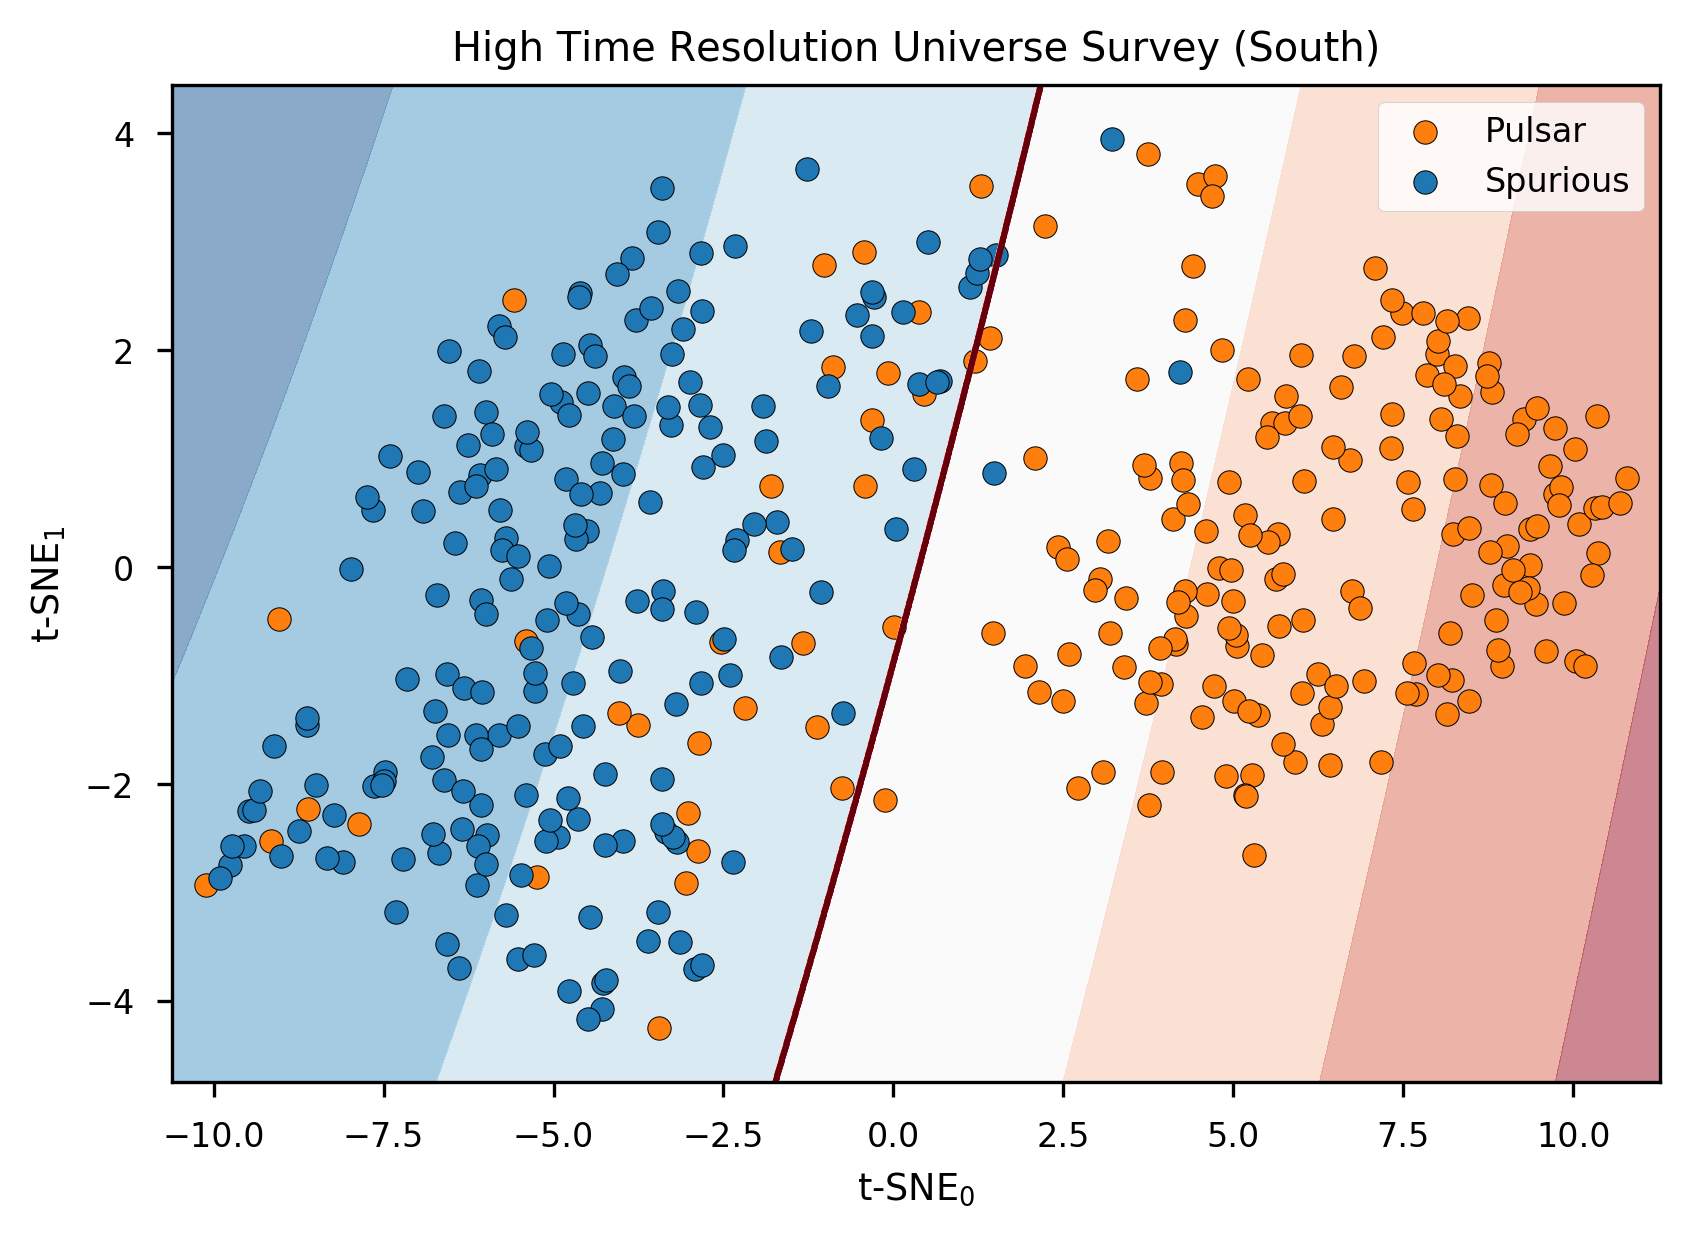

In [6]:
from sklearn.svm import SVC

h = 0.01
x_min, x_max = X_r[:, 0].min() - .5, X_r[:, 0].max() + .5
y_min, y_max = X_r[:, 1].min() - .5, X_r[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

clf = SVC(C=500, kernel='rbf', gamma=0.0001)
clf.fit(X_r, y[idx])


Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z2 = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
Z2 = Z2.reshape(xx.shape)

plt.figure(dpi=300)
plt.contourf(xx, yy, Z, cmap='RdBu_r', alpha=.5)
plt.contour(xx, yy, Z2, cmap='Reds', alpha=1)

x1 = X_r[:, 0]
x2 = X_r[:, 1]

plt.scatter(x1[:samples_per_class], x2[:samples_per_class], c='C1', label='Pulsar', marker='o', edgecolors='k')
plt.scatter(x1[samples_per_class:], x2[samples_per_class:], c='C0', label='Spurious', marker='o', edgecolors='k')

plt.legend()
plt.title('High Time Resolution Universe Survey (South)')
plt.xlabel(r't-SNE$_0$')
plt.ylabel(r't-SNE$_1$')
plt.savefig('../images/classification_underfit.png');

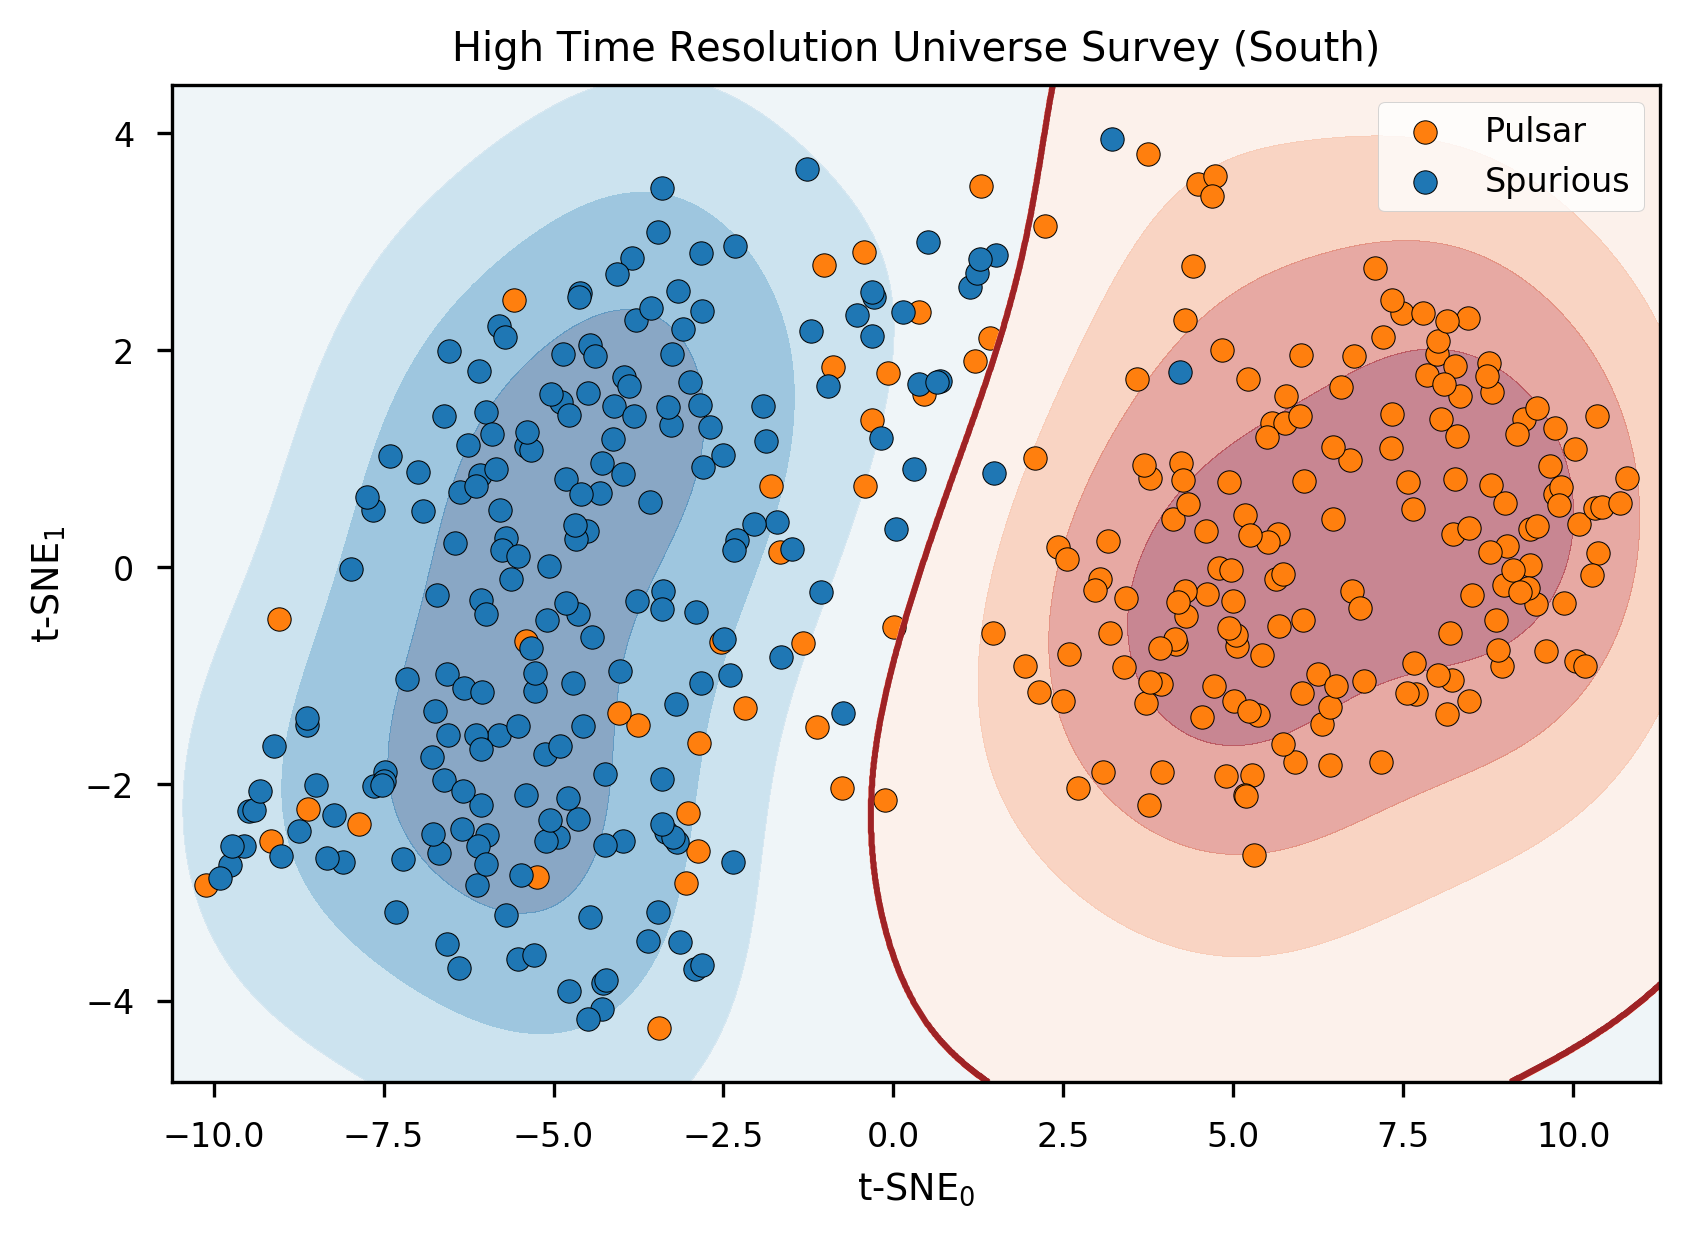

In [7]:
from sklearn.model_selection import GridSearchCV

params = {'C': np.logspace(-3, 1, 20),
          'gamma': np.logspace(-3, 1, 20)}

#clf = SVC(C=0.5455, kernel='rbf', gamma=0.8)
clf = GridSearchCV(SVC(kernel='rbf'), param_grid=params, n_jobs=-1, cv=5)
clf.fit(X_r, y[idx])


Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z2 = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
Z2 = Z2.reshape(xx.shape)

plt.figure(dpi=300)
plt.contourf(xx, yy, Z, cmap='RdBu_r', alpha=.5) # background
plt.contour(xx, yy, Z2, cmap='Reds', alpha=.5) # borders

x1 = X_r[:, 0]
x2 = X_r[:, 1]

plt.scatter(x1[:samples_per_class], x2[:samples_per_class], c='C1', label='Pulsar', marker='o', edgecolors='k')
plt.scatter(x1[samples_per_class:], x2[samples_per_class:], c='C0', label='Spurious', marker='o', edgecolors='k')

plt.legend()
plt.title('High Time Resolution Universe Survey (South)')
plt.xlabel(r't-SNE$_0$')
plt.ylabel(r't-SNE$_1$')
plt.savefig('../images/classification_fit.png');

In [8]:
clf.best_estimator_.get_params()

{'C': 0.029763514416313176,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.20691380811147903,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

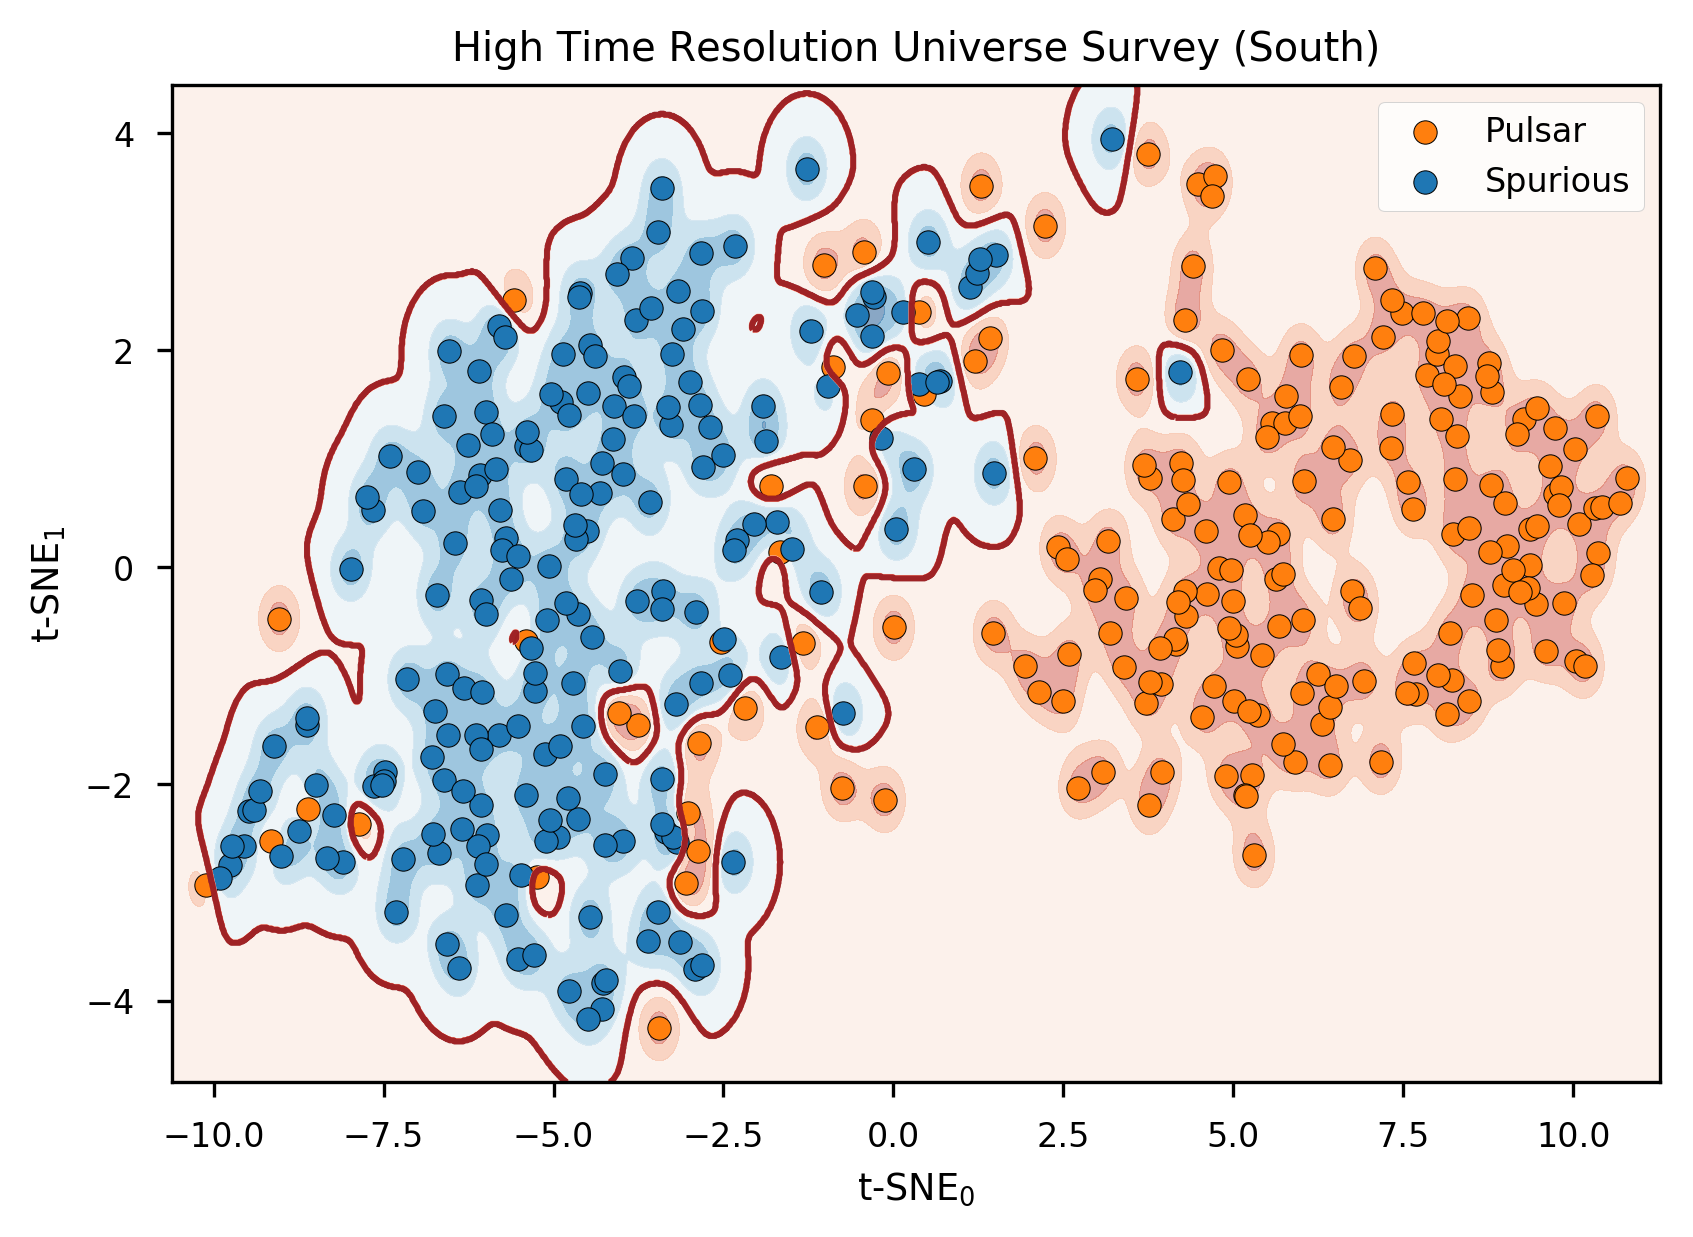

In [9]:
clf = SVC(C=1, kernel='rbf', gamma=10)
clf.fit(X_r, y[idx])


Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z2 = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
Z2 = Z2.reshape(xx.shape)

plt.figure(dpi=300)
plt.contourf(xx, yy, Z, cmap='RdBu_r', alpha=.5)
plt.contour(xx, yy, Z2, cmap='Reds', alpha=.5)

x1 = X_r[:, 0]
x2 = X_r[:, 1]

plt.scatter(x1[:samples_per_class], x2[:samples_per_class], c='C1', label='Pulsar', marker='o', edgecolors='k')
plt.scatter(x1[samples_per_class:], x2[samples_per_class:], c='C0', label='Spurious', marker='o', edgecolors='k')

plt.legend()
plt.title('High Time Resolution Universe Survey (South)')
plt.xlabel(r't-SNE$_0$')
plt.ylabel(r't-SNE$_1$')
plt.savefig('../images/classification_overfit.png');